In [7]:
import numpy as np
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM
from PIL import Image
import os
import glob
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm


def get_named_linears(module):
    return {name: m for name, m in module.named_modules() if isinstance(m, nn.Linear)}

def get_blocks(model):
    if model.__class__.__name__ in ("LlamaForCausalLM", "Qwen2ForCausalLM"):
        layers = model.model.layers
    elif model.__class__.__name__ == "LlavaLlamaForCausalLM":
        layers = model.model.layers
    elif isinstance(model, OPTForCausalLM):
        layers = model.model.decoder.layers
    elif isinstance(model, BloomForCausalLM):
        layers = model.transformer.h
    elif "mpt" in str(model.__class__).lower():
        layers = model.transformer.blocks
    elif "falcon" in str(model.__class__).lower():
        layers = model.transformer.h
    elif "bigcode" in str(model.__class__).lower():
        layers = model.transformer.h
    elif "neox" in str(model.__class__).lower():
        layers = model.gpt_neox.layers
    elif model.__class__.__name__ == "LlavaLlamaModel":
        layers = model.llm.model.layers
    else:
        raise NotImplementedError(type(model))
    return layers

def load_image_data(image_dir, num_images=5, sample_size=100000):
    """Loads and samples pixel data from random images."""
    print(f"Loading image data from: {image_dir}")
    try:
        image_paths = glob.glob(os.path.join(image_dir, '**', '*.JPEG'), recursive=True)
        if not image_paths:
            raise FileNotFoundError(f"No JPEG images found in {image_dir}. Please check the path.")
            
        selected_paths = random.sample(image_paths, min(num_images, len(image_paths)))
        
        all_pixels = []
        for path in selected_paths:
            with Image.open(path).convert('L') as img: # Convert to grayscale
                pixels = np.array(img, dtype=np.float32) / 255.0 # Normalize to [0, 1]
                all_pixels.append(pixels.flatten())
        
        combined_pixels = np.concatenate(all_pixels)
        
        # Sample the pixels to keep the plot manageable
        if len(combined_pixels) > sample_size:
            sampled_pixels = np.random.choice(combined_pixels, sample_size, replace=False)
        else:
            sampled_pixels = combined_pixels
            
        print(f"Successfully loaded and sampled {len(sampled_pixels)} pixels from {len(selected_paths)} images.")
        return sampled_pixels
    except Exception as e:
        print(f"Error loading image data: {e}")
        return None

def normalize_data(data):
    """Normalizes a numpy array to have a mean of 0 and variance of 1."""
    return (data - np.mean(data)) / np.std(data)

# def create_violin_plot(data_dict, title, save_path):
#     """Creates and saves a violin plot from a dictionary of data."""
#     # Convert data to a long-form DataFrame for Seaborn
#     df_list = []
#     for label, data in data_dict.items():
#         df_list.append(pd.DataFrame({'value': data, 'category': label}))
#     df = pd.concat(df_list, ignore_index=True)

#     plt.style.use('seaborn-v0_8-whitegrid')
#     fig, ax = plt.subplots(figsize=(12, 8))
    
#     sns.violinplot(x='category', y='value', data=df, ax=ax, cut=0, inner='quartile')
    
#     ax.set_title(title, fontsize=20, pad=20)
#     ax.set_xlabel("Data Source", fontsize=14)
#     ax.set_ylabel("Value (normalized)", fontsize=14)
#     plt.xticks(rotation=45, ha="right")
#     plt.tight_layout()
    
#     plt.rcParams['font.size'] = 12
#     plt.rcParams['axes.titlesize'] = 16
#     plt.rcParams['axes.labelsize'] = 14
#     plt.rcParams['xtick.labelsize'] = 12
#     plt.rcParams['ytick.labelsize'] = 12
#     plt.rcParams['legend.fontsize'] = 11
#     plt.rcParams['figure.titlesize'] = 18
    
#     os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
#     plt.savefig(save_path)
#     print(f"Plot saved to: {save_path}")
#     plt.show()

## 수정된 create_violin_plot 함수 ##

def create_violin_plot(data_dict, title, save_path, extreme_values=None):
    """Creates and saves a violin plot from a dictionary of data."""
    df_list = []
    for label, data in data_dict.items():
        df_list.append(pd.DataFrame({'value': data, 'category': label}))
    df = pd.concat(df_list, ignore_index=True)

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # 카테고리 순서를 data_dict의 키 순서대로 고정
    category_order = list(data_dict.keys())
    sns.violinplot(x='category', y='value', data=df, ax=ax, cut=0, inner='quartile', order=category_order)
    
    ## --- 추가된 부분: 실제 Min/Max 값을 플롯에 표시 --- ##
    if extreme_values:
        # 각 카테고리의 x축 위치 (0, 1, 2, ...)에 맞춰 선을 그립니다.
        for i, category in enumerate(category_order):
            if category in extreme_values:
                true_min, true_max = extreme_values[category]
                # hlines로 min/max 위치에 붉은색 수평선을 긋습니다.
                # xmin/xmax로 선의 길이를 조절합니다.
                # 범례(legend)에 한 번만 표시되도록 label을 설정합니다.
                ax.hlines(y=[true_min, true_max], xmin=i-0.2, xmax=i+0.2, 
                          colors='red', lw=2, linestyles='solid', 
                          label='True Min/Max' if i == 0 else "")
        # 범례를 표시합니다.
        ax.legend()
    ## ---------------------------------------------------- ##

    ax.set_title(title, fontsize=20, pad=20)
    ax.set_xlabel("Data Source", fontsize=14)
    ax.set_ylabel("Value (normalized)", fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    plt.savefig(save_path)
    print(f"Plot saved to: {save_path}")
    plt.close(fig) # 메모리 관리를 위해 플롯을 닫아줍니다.


In [8]:
model_list = [
    'meta-llama/Meta-Llama-3-8B',
    'meta-llama--Llama-2-7b-hf',
    # 'meta-llama--Llama-2-13b-hf',
]

IMAGE_DATA_DIR = '/data/ILSVRC2012/val' # Path to ImageNet validation set
WEIGHT_SAMPLE_SIZE = 1000000 # Number of weights to sample from each matrix
OUTPUT_DIR = "./plots/ele_dist_normalized_viloin"
std_normal = np.random.randn(WEIGHT_SAMPLE_SIZE)
## 수정된 메인 로직 ##

for model_name in model_list:
    model_name = model_name.replace('/', '--')
    print('model_name: ', model_name)
    
    model_path = f"../Wparam_dataset/hf_model/{model_name}"

    model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True)
    layers = get_blocks(model)

    for i in [0, 1, 10, 31]:
        named_linears = get_named_linears(layers[i])
        for n, m in named_linears.items():
            W = m.weight.data.detach().cuda()
            norm_data = {}
            extreme_values = {} # 실제 min/max를 저장할 딕셔너리
            epsilon = 1e-8 # 0으로 나누는 것을 방지

            # --- Overall Normalized ---
            WN_full = (W - W.mean()) / (W.std() + epsilon)
            extreme_values['Overall Normalized'] = (WN_full.min().item(), WN_full.max().item()) # 실제 min/max 저장
            WN = WN_full.cpu().numpy().flatten()
            if len(WN) > WEIGHT_SAMPLE_SIZE:
                WN = np.random.choice(WN, WEIGHT_SAMPLE_SIZE, replace=False)
            norm_data['Overall Normalized'] = WN
            
            # --- Row-wise Normalized ---
            WN_full = (W - W.mean(dim=1, keepdim=True)) / (W.std(dim=1, keepdim=True) + epsilon)
            extreme_values['Row-wise Normalized'] = (WN_full.min().item(), WN_full.max().item()) # 실제 min/max 저장
            WN = WN_full.cpu().numpy().flatten()
            if len(WN) > WEIGHT_SAMPLE_SIZE:
                WN = np.random.choice(WN, WEIGHT_SAMPLE_SIZE, replace=False)
            norm_data['Row-wise Normalized'] = WN
       
            # --- Column-wise Normalized ---
            WN_full = (W - W.mean(dim=0, keepdim=True)) / (W.std(dim=0, keepdim=True) + epsilon)
            extreme_values['Column-wise Normalized'] = (WN_full.min().item(), WN_full.max().item()) # 실제 min/max 저장
            WN = WN_full.cpu().numpy().flatten()
            if len(WN) > WEIGHT_SAMPLE_SIZE:
                WN = np.random.choice(WN, WEIGHT_SAMPLE_SIZE, replace=False)
            norm_data['Column-wise Normalized'] = WN
        
            # --- Row then Col Normalized ---
            W_row_norm = (W - W.mean(dim=1, keepdim=True)) / (W.std(dim=1, keepdim=True) + epsilon)
            WN_full = (W_row_norm - W_row_norm.mean(dim=0, keepdim=True)) / (W_row_norm.std(dim=0, keepdim=True) + epsilon)
            extreme_values['Row then Col Normalized'] = (WN_full.min().item(), WN_full.max().item()) # 실제 min/max 저장
            WN = WN_full.cpu().numpy().flatten()
            if len(WN) > WEIGHT_SAMPLE_SIZE:
                WN = np.random.choice(WN, WEIGHT_SAMPLE_SIZE, replace=False)
            norm_data['Row then Col Normalized'] = WN
    
            norm_data['Standard Normal'] = std_normal
            # Standard Normal은 이론적인 분포이므로 별도의 min/max는 추가하지 않습니다.

            plot_title_normalized = f'{i}_{n}'
            n_short = n.split(".")[-1]
            save_path_normalized = os.path.join(OUTPUT_DIR, model_name, n_short, f'{i}_{n_short}.png')

            # create_violin_plot 함수에 extreme_values 인자 전달
            create_violin_plot(norm_data, plot_title_normalized, save_path_normalized, extreme_values)

model_name:  meta-llama--Meta-Llama-3-8B


Loading checkpoint shards: 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Plot saved to: ./plots/ele_dist_normalized_viloin/meta-llama--Meta-Llama-3-8B/q_proj/0_q_proj.png
Plot saved to: ./plots/ele_dist_normalized_viloin/meta-llama--Meta-Llama-3-8B/k_proj/0_k_proj.png
Plot saved to: ./plots/ele_dist_normalized_viloin/meta-llama--Meta-Llama-3-8B/v_proj/0_v_proj.png
Plot saved to: ./plots/ele_dist_normalized_viloin/meta-llama--Meta-Llama-3-8B/o_proj/0_o_proj.png
Plot saved to: ./plots/ele_dist_normalized_viloin/meta-llama--Meta-Llama-3-8B/gate_proj/0_gate_proj.png
Plot saved to: ./plots/ele_dist_normalized_viloin/meta-llama--Meta-Llama-3-8B/up_proj/0_up_proj.png
Plot saved to: ./plots/ele_dist_normalized_viloin/meta-llama--Meta-Llama-3-8B/down_proj/0_down_proj.png
Plot saved to: ./plots/ele_dist_normalized_viloin/meta-llama--Meta-Llama-3-8B/q_proj/1_q_proj.png
Plot saved to: ./plots/ele_dist_normalized_viloin/meta-llama--Meta-Llama-3-8B/k_proj/1_k_proj.png
Plot saved to: ./plots/ele_dist_normalized_viloin/meta-llama--Meta-Llama-3-8B/v_proj/1_v_proj.png
Plot s

Loading checkpoint shards: 100%|██████████| 6/6 [00:01<00:00,  3.98it/s]


Plot saved to: ./plots/ele_dist_normalized_viloin/meta-llama--Llama-2-7b-hf/q_proj/0_q_proj.png
Plot saved to: ./plots/ele_dist_normalized_viloin/meta-llama--Llama-2-7b-hf/k_proj/0_k_proj.png
Plot saved to: ./plots/ele_dist_normalized_viloin/meta-llama--Llama-2-7b-hf/v_proj/0_v_proj.png
Plot saved to: ./plots/ele_dist_normalized_viloin/meta-llama--Llama-2-7b-hf/o_proj/0_o_proj.png
Plot saved to: ./plots/ele_dist_normalized_viloin/meta-llama--Llama-2-7b-hf/gate_proj/0_gate_proj.png
Plot saved to: ./plots/ele_dist_normalized_viloin/meta-llama--Llama-2-7b-hf/up_proj/0_up_proj.png
Plot saved to: ./plots/ele_dist_normalized_viloin/meta-llama--Llama-2-7b-hf/down_proj/0_down_proj.png
Plot saved to: ./plots/ele_dist_normalized_viloin/meta-llama--Llama-2-7b-hf/q_proj/1_q_proj.png
Plot saved to: ./plots/ele_dist_normalized_viloin/meta-llama--Llama-2-7b-hf/k_proj/1_k_proj.png
Plot saved to: ./plots/ele_dist_normalized_viloin/meta-llama--Llama-2-7b-hf/v_proj/1_v_proj.png
Plot saved to: ./plots/ele

In [8]:
def load_image_data(image_dir, num_images=5, sample_size=100000):
    """Loads and samples pixel data from random images."""
    print(f"Loading image data from: {image_dir}")
    try:
        image_paths = glob.glob(os.path.join(image_dir, '**', '*.JPEG'), recursive=True)
        if not image_paths:
            raise FileNotFoundError(f"No JPEG images found in {image_dir}. Please check the path.")
            
        selected_paths = random.sample(image_paths, min(num_images, len(image_paths)))
        
        all_pixels = []
        for path in selected_paths:
            with Image.open(path).convert('L') as img: # Convert to grayscale
                pixels = np.array(img, dtype=np.float32) / 255.0 # Normalize to [0, 1]
                all_pixels.append(pixels.flatten())
        
        combined_pixels = np.concatenate(all_pixels)
        
        # Sample the pixels to keep the plot manageable
        if len(combined_pixels) > sample_size:
            sampled_pixels = np.random.choice(combined_pixels, sample_size, replace=False)
        else:
            sampled_pixels = combined_pixels
            
        print(f"Successfully loaded and sampled {len(sampled_pixels)} pixels from {len(selected_paths)} images.")
        return sampled_pixels
    except Exception as e:
        print(f"Error loading image data: {e}")
        return None

def normalize_data(data):
    """Normalizes a numpy array to have a mean of 0 and variance of 1."""
    return (data - np.mean(data)) / np.std(data)

def create_violin_plot(data_dict, title, save_path):
    """Creates and saves a violin plot from a dictionary of data."""
    # Convert data to a long-form DataFrame for Seaborn
    df_list = []
    for label, data in data_dict.items():
        df_list.append(pd.DataFrame({'value': data, 'category': label}))
    df = pd.concat(df_list, ignore_index=True)

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 8))
    
    sns.violinplot(x='category', y='value', data=df, ax=ax, cut=0, inner='quartile')
    
    ax.set_title(title, fontsize=20, pad=20)
    ax.set_xlabel("Data Source", fontsize=14)
    ax.set_ylabel("Value (normalized)", fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.titlesize'] = 16
    plt.rcParams['axes.labelsize'] = 14
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    plt.rcParams['legend.fontsize'] = 11
    plt.rcParams['figure.titlesize'] = 18
    
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    plt.savefig(save_path)
    print(f"Plot saved to: {save_path}")
    plt.show()


Loading model: meta-llama/Meta-Llama-3-8B


Loading checkpoint shards: 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


Analyzing weights from layer 15...
  - Collected 'self_attn.o_proj' weights, shape: (1000000,)
Plot saved to: ./plots/layer_15_normalized_distributions_with_gaussian.png


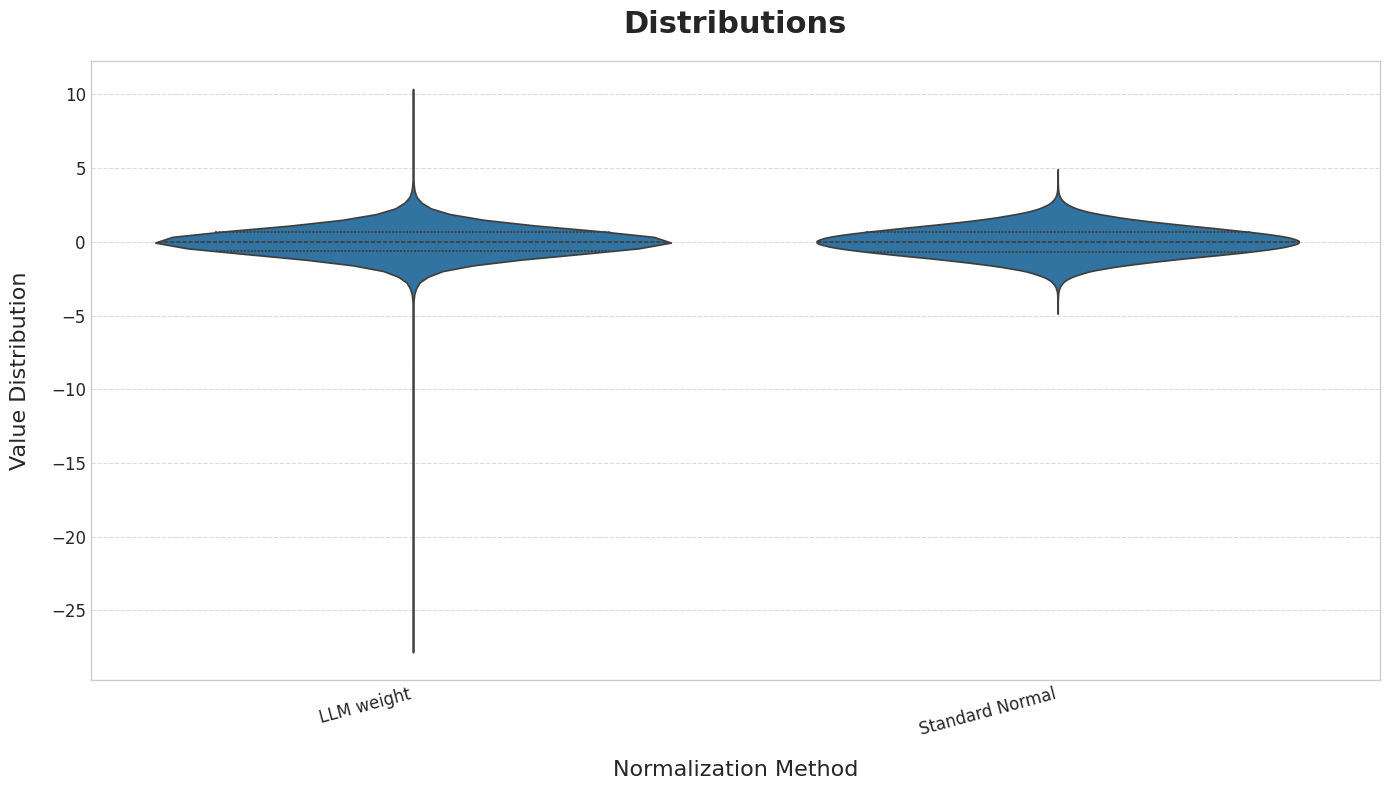

In [2]:

# --- Main Script ---

# 1. Configuration
# Important: Adjust these paths to match your system
# MODEL_NAME = 'meta-llama/Llama-2-7b-hf'
# MODEL_PATH = f"../Wparam_dataset/hf_model/{MODEL_NAME.replace('/', '--')}" # Path to your downloaded HF model
MODEL_PATH = '/workspace/Weight_compression/Wparam_dataset/hf_model/meta-llama--Meta-Llama-3-8B'
IMAGE_DATA_DIR = '/data/ILSVRC2012/val' # Path to ImageNet validation set
LAYER_TO_ANALYZE = 15 # Example layer index to analyze
WEIGHT_SAMPLE_SIZE = 1000000 # Number of weights to sample from each matrix
OUTPUT_DIR = "./plots"



# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 2. Load Image Data
# image_data = load_image_data(IMAGE_DATA_DIR, num_images=10, sample_size=WEIGHT_SAMPLE_SIZE)
# if image_data is None:
#     exit() # Exit if image loading fails

# 3. Load Model and Collect Weights
try:
    print(f"Loading model: {MODEL_NAME}")
    model = AutoModelForCausalLM.from_pretrained(MODEL_PATH, local_files_only=True, torch_dtype=torch.float16).eval()
    layers = get_blocks(model)

    print(f"Analyzing weights from layer {LAYER_TO_ANALYZE}...")
    target_layer = layers[LAYER_TO_ANALYZE]
    named_linears = get_named_linears(target_layer)

    # weight_keys = ['self_attn.q_proj', 'self_attn.k_proj', 'self_attn.v_proj', 'self_attn.o_proj', 'mlp.gate_proj', 'mlp.up_proj', 'mlp.down_proj']
    # weight_keys = ['self_attn.q_proj', 'self_attn.o_proj', 'mlp.gate_proj', 'mlp.up_proj']
    weight_keys = ['self_attn.o_proj']
        
    raw_data = {}
    
    for key in weight_keys:
        if key in named_linears:
            W = named_linears[key].weight.data.detach().cpu().numpy().flatten()
            if len(W) > WEIGHT_SAMPLE_SIZE:
                W = np.random.choice(W, WEIGHT_SAMPLE_SIZE, replace=False)
            # raw_data[key] = W
            raw_data['LLM weight'] = W
            print(f"  - Collected '{key}' weights, shape: {W.shape}")
        else:
            print(f"  - Warning: Weight '{key}' not found in layer {LAYER_TO_ANALYZE}.")


    # # Add image data to the dictionary
    # raw_data['Image Pixels'] = image_data

except Exception as e:
    print(f"An error occurred during model loading or weight extraction: {e}")
    exit()

# # 4. Create Plots
# # Plot 1: Raw Data Distributions
# plot_title_raw = f"Raw Data Distributions (Layer {LAYER_TO_ANALYZE} of {MODEL_NAME})"
# save_path_raw = os.path.join(OUTPUT_DIR, f"layer_{LAYER_TO_ANALYZE}_raw_distributions.png")
# create_violin_plot(raw_data, plot_title_raw, save_path_raw)

# Plot 2: Normalized Data Distributions
normalized_data = {key: normalize_data(val) for key, val in raw_data.items()}
normalized_data = {key: normalize_data(val) for key, val in raw_data.items()}
std_normal = np.random.randn(WEIGHT_SAMPLE_SIZE)
normalized_with_normal = normalized_data.copy()
normalized_with_normal['Standard Normal'] = std_normal

plot_title_normalized = f"Distributions"
save_path_normalized = os.path.join(OUTPUT_DIR, f"layer_{LAYER_TO_ANALYZE}_normalized_distributions_with_gaussian.png")
create_violin_plot(normalized_with_normal, plot_title_normalized, save_path_normalized)

In [10]:
from scipy.stats import gaussian_kde
import numpy as np
import os
import matplotlib.pyplot as plt

def create_kde_overlay(raw_data, layer_idx, output_dir):
    weight = raw_data['self_attn.o_proj']
    pixels = raw_data['Image Pixels']
    gaussian = np.random.randn(len(weight))
    
    # 공통 그리드 생성
    data_min = min(weight.min(), pixels.min(), gaussian.min())
    data_max = max(weight.max(), pixels.max(), gaussian.max())
    grid = np.linspace(data_min, data_max, 1000)
    
    # KDE 계산
    kde_weight = gaussian_kde(weight)
    kde_gauss  = gaussian_kde(gaussian)
    kde_pixels = gaussian_kde(pixels)
    
    # 플롯
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.plot(grid, kde_weight(grid), label='Weight Distribution')
    ax.plot(grid, kde_gauss(grid),  label='Gaussian')
    ax.plot(grid, kde_pixels(grid), label='Pixel Values')
    ax.set_title(f"Overlay KDE of Distributions (Layer {layer_idx})", fontsize=20, pad=20)
    ax.set_xlabel("Value", fontsize=14)
    ax.set_ylabel("Density", fontsize=14)
    ax.legend()
    plt.tight_layout()
    
    # 저장 및 표시
    save_path = os.path.join(output_dir, f"layer_{layer_idx}_overlay_kde.png")
    plt.savefig(save_path)
    print(f"KDE overlay plot saved to: {save_path}")
    plt.show()

# 호출 예시 (raw_data 정의 이후에)
create_kde_overlay(normalized_with_normal, LAYER_TO_ANALYZE, OUTPUT_DIR)


KeyError: 'self_attn.o_proj'